In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import copy
import time
from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from matplotlib import gridspec

% matplotlib inline

UsageError: Line magic function `%` not found.


<img src="files/howard_transits.png" style="width: 350px;">

## Goal: Get planet occurrence rate data from Howard et al. 2012: https://arxiv.org/abs/1103.2541

### These are planets with P < 50d orbiting G and K stars in the Kepler survey, so these are occurrence rates for short-period planets around "Sun-like" stars.

| Radius range [R_Earth] | Mass range [M_Earth] | Mass range [M_Sun] | Occurrence rate *f*|
|------------------------|----------------------|--------------------|--------------------|
| 2-4                    | 3-25                 | 9.e-6 - 7.5e-5     | 0.130 +- 0.008     |
| 4-8                    | 9-7800               | 2.7e-5 - 2.3e-2    | 0.023 +- 0.003     |
| 8-32                   | 34-95,000            | 1.e-4 - 2.9e-1     | 0.013 +- 0.002     |


### In the above table, I have used Chen & Kipping's Forecaster model (https://arxiv.org/abs/1603.08614) to make a rough conversion of Earth radii to Earth masses.

2 Rearth: M = 4.890 (+ 4.508 - 1.948) MEarth

4 Rearth: M = 15.949 (+ 9.483 - 7.300) MEarth

8 Rearth: M = 57.706 (+ 7733.247 - 23.705) MEarth

32 Rearth: M = 86401.149 (+ 9441.665 - 10110.472) MEarth

### The occurrence rate $f$ is in units of number of planets/star, so we need to multiply by the number density of GK dwarfs in the Kepler field.

### How do we do this? Their selection of GK stars is magnitude-limited, among other cuts:
- only stars with Kp < 15 mag
- only stars with Teff in the range [4100, 6100] K
- only stars with logg in the range [4.0, 4.9]
- only stars of "high photometric quality"

which leaves ~58,000 target stars, only about a third of the total number of Kepler target stars.

Converting this into a number density isn't straightforward, because it's a magnitude-limited, not volume-limited, sample.

Idea: use the Gaia-Kepler cross-matched catalog by Megan Bedell (https://gaia-kepler.fun/) to estimate it.



In [3]:
hdu1 = fits.open("../../things/planets/kepler_dr2_1arcsec.fits")
data = hdu1[1]
data.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  991 / length of dimension 1                          
NAXIS2  =               201312 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  134 / number of table fields                         
TTYPE1  = 'solution_id'                                                         
TFORM1  = 'K       '                                                            
TNULL1  =               999999                                                  
TTYPE2  = 'designation'                                                         
TFORM2  = '28A     '        

In [4]:
print(type(data.data['kepmag']))
print(len(data.data['kepmag']))

kepmag = data.data['kepmag'] #magnitudes 
teff = data.data['teff'] #kelvins
logg = data.data['logg']
gaiamag = data.data['phot_g_mean_mag'] #magnitudes
parallax = data.data['parallax'] #milliarcsec
parallax_as = parallax/1000. #arcsec
dist = 1./parallax_as #parsecs
RA = data.data['ra_kic'] #degrees
dec = data.data['dec_kic'] #degrees

#do we get roughly the same number of stars in the sample if we apply the same cuts as Howard+2012?
#also cut out bad parallaxes and nans
subsampleMask = ((kepmag < 15) & 
                (teff >= 4100) & (teff <= 6100) & 
                (logg >= 4.0) & (logg <= 4.9) & 
                (dist > 0.) & 
                (~np.isnan(RA)) & 
                (~np.isnan(dec)) & 
                (~np.isnan(dist)))
print(len(kepmag[subsampleMask]))

allGKmask = ((teff >= 4100) & (teff <= 6100) & 
            (logg >= 4.0) & (logg <= 4.9) & 
            (dist > 0.) & 
            (~np.isnan(RA)) & 
            (~np.isnan(dec)) & 
            (~np.isnan(dist)))
print(len(kepmag[allGKmask]))

#Ehh, order-of-magnitude okay. We have ~45,000 to their ~58,000.

<class 'numpy.ndarray'>
201312
44769
104997


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in less
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in greater


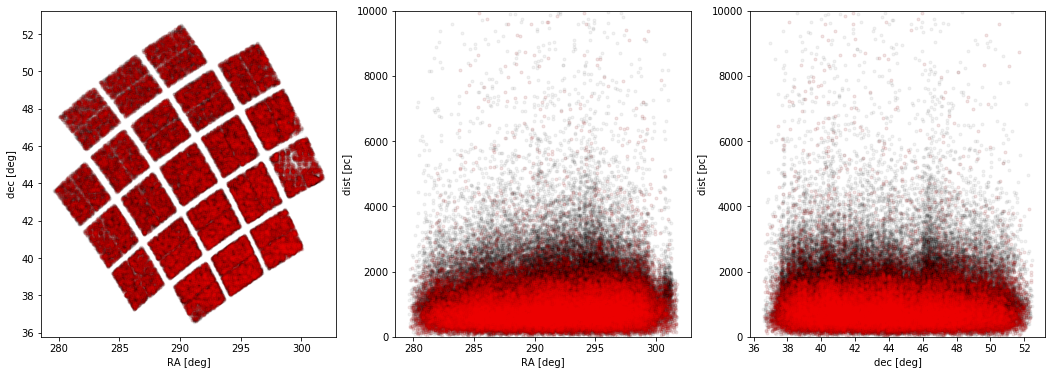

In [5]:
#plot these to see if they make decent sense...aww yeah

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(RA[allGKmask],dec[allGKmask],'k.',alpha=0.05)
axes[0].plot(RA[subsampleMask],dec[subsampleMask],'r.',alpha=0.05)
axes[0].set_xlabel("RA [deg]")
axes[0].set_ylabel("dec [deg]")

axes[1].plot(RA[allGKmask],dist[allGKmask],'k.',alpha=0.05)
axes[1].plot(RA[subsampleMask],dist[subsampleMask],'r.',alpha=0.05)
axes[1].set_xlabel("RA [deg]")
axes[1].set_ylabel("dist [pc]")
axes[1].set_ylim(0,10000)

axes[2].plot(dec[allGKmask],dist[allGKmask],'k.',alpha=0.05)
axes[2].plot(dec[subsampleMask],dist[subsampleMask],'r.',alpha=0.05)
axes[2].set_xlabel("dec [deg]")
axes[2].set_ylabel("dist [pc]")
axes[2].set_ylim(0,10000)

plt.show()

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in true_divide


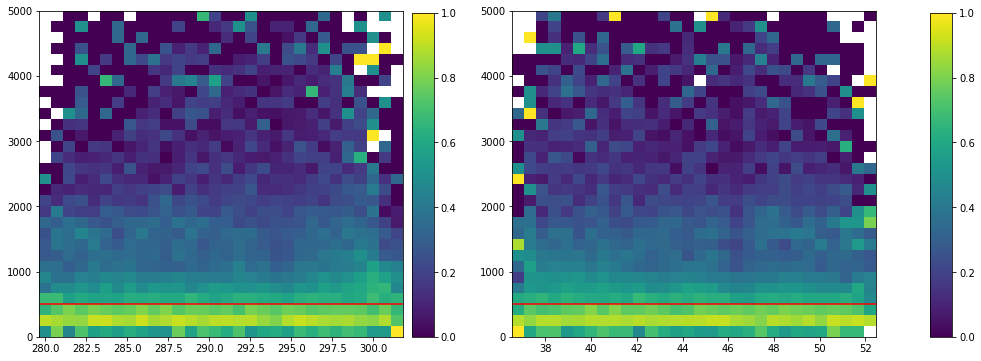

In [6]:
# so! out to what distance is the Howard+2012 sub-sample more or less complete? 

fig, axes = plt.subplots(1,2,figsize=(15,6))

hAll,xedges,yedges,im = axes[0].hist2d(RA[allGKmask],dist[allGKmask],bins=30,range=((np.min(RA),np.max(RA)),(0,5000)),alpha=0)
hSub,xedges,yedges,im = axes[0].hist2d(RA[subsampleMask],dist[subsampleMask],bins=30,range=((np.min(RA),np.max(RA)),(0,5000)),alpha=0)

im = axes[0].imshow((hSub/hAll).T,
                    aspect='auto',
                    extent=(np.min(RA),np.max(RA),0,5000),
                    origin='lower',
                    interpolation='nearest',
                    cmap='viridis',
                    vmin=0.,
                    vmax=1.)

cax = fig.add_axes([0.47, 0.125, 0.02, 0.75])

fig.colorbar(im, cax=cax)

hAll,xedges,yedges,im = axes[1].hist2d(dec[allGKmask],dist[allGKmask],bins=30,range=((np.min(dec),np.max(dec)),(0,5000)),alpha=0)
hSub,xedges,yedges,im = axes[1].hist2d(dec[subsampleMask],dist[subsampleMask],bins=30,range=((np.min(dec),np.max(dec)),(0,5000)),alpha=0)

im2 = axes[1].imshow((hSub/hAll).T,
                    aspect='auto',
                    extent=(np.min(dec),np.max(dec),0,5000),
                    origin='lower',
                    interpolation='nearest',
                    cmap='viridis',
                    vmin=0.,
                    vmax=1.)

cax2 = fig.add_axes([0.95, 0.125, 0.02, 0.75])

fig.colorbar(im2, cax=cax2)

axes[0].axhline(500,color='r')
axes[1].axhline(500,color='r')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [7]:
# so from the above figure, I conclude that the subsample is ~complete out to ~500pc (i.e., all the GK dwarfs within 
# ~500 pc will be picked up and included in the subsample with kepmag < 15).

#So! How many GK dwarfs match our criteria within ~500 pc, and what number density does that correspond to?
nearGKmask = ((kepmag < 15) &
            (teff >= 4100) & (teff <= 6100) & 
            (logg >= 4.0) & (logg <= 4.9) & 
            (dist > 0.) & 
            (dist <= 500.) &
            (~np.isnan(RA)) & 
            (~np.isnan(dec)) & 
            (~np.isnan(dist)))

nStar = len(kepmag[nearGKmask])
print(nStar)

#The volume we must divide by is a cone of height 500pc and "area" = 115 deg^2, the Kepler field of view... 
solidAngle = (115. * (np.pi/180.)**2)
vol = (4*np.pi/3.)*solidAngle*500**3
dStar_dV = nStar/vol #pc^-3
print(dStar_dV)

9357
0.0005101353646540646


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less_equal


In [8]:
#instead --- dN_GK/dV from the IMF
dStar_dV = 1.e-11

## Get individual mass bins

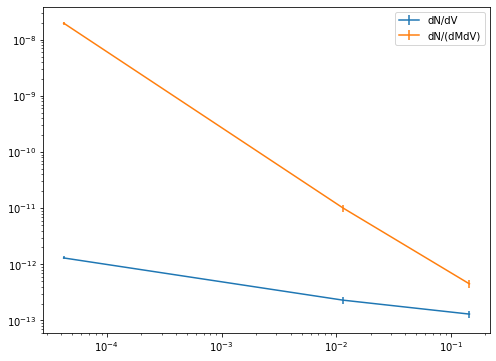

In [9]:
mbins_lower = np.array((9.e-6, 2.7e-5, 1.e-4))
mbins_upper = np.array((7.5e-5, 2.3e-2,2.9e-1))
mbins_mid = mbins_lower + (mbins_upper - mbins_lower)/2.
mbins_intervals = mbins_upper - mbins_lower

dNdV_indiv = (dStar_dV * np.array((0.130,0.023,0.013))) 
dNdV_upperunc_indiv = (dStar_dV * np.array((0.008,0.003,0.002))) 
dNdV_lowerunc_indiv = (dStar_dV * np.array((0.008,0.003,0.002))) 

dNdMdV_indiv = (dStar_dV * np.array((0.130,0.023,0.013))) / mbins_intervals
dNdMdV_upperunc_indiv = (dStar_dV * np.array((0.008,0.003,0.002))) / mbins_intervals
dNdMdV_lowerunc_indiv = (dStar_dV * np.array((0.008,0.003,0.002))) / mbins_intervals

dNdlogMdV_indiv = (dStar_dV * np.array((0.130,0.023,0.013))) / np.log10(mbins_intervals)
dNdlogMdV_upperunc_indiv = (dStar_dV * np.array((0.008,0.003,0.002))) / np.log10(mbins_intervals)
dNdlogMdV_lowerunc_indiv = (dStar_dV * np.array((0.008,0.003,0.002))) / np.log10(mbins_intervals)


#fbins_indiv_univ = 5.e-10 * np.array((0.130,0.023,0.013)) / mbins_intervals
#fbins_upperunc_indiv_univ = 5.e-10 * np.array((0.008,0.003,0.002)) / mbins_intervals
#fbins_lowerunc_indiv_univ = 5.e-10 * np.array((0.008,0.003,0.002)) / mbins_intervals

#If a sequence of shape 2xN, errorbars are drawn at -row1 and +row2 relative to the data.
fig = plt.figure(figsize=(8,6))
plt.errorbar(mbins_mid, dNdV_indiv, yerr=np.vstack((dNdV_lowerunc_indiv,dNdV_upperunc_indiv)),label="dN/dV")
plt.errorbar(mbins_mid, dNdMdV_indiv, yerr=np.vstack((dNdMdV_lowerunc_indiv,dNdMdV_upperunc_indiv)),label="dN/(dMdV)")
plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.show()

In [10]:
#transitBinsData =np.vstack((mbins_indiv,fbins_indiv,fbins_upperunc_indiv,fbins_lowerunc_indiv)).T
transitData = np.vstack((mbins_mid, np.log10(mbins_intervals), dNdV_indiv, dNdlogMdV_indiv)).T
np.savetxt('../data/transitingPlanets_GK.txt',transitData,fmt='%1.3e \t',header='PlanetstransitingGKstars.   Bin center, log10(M [M_\odot]) 	 Bin width, log10(M [M_\odot])     dN / dV [pc^-3]     dN / (dV dlogM) [pc^-3 log10(M / M\odot)]')

In [10]:
#transitBinsData_univ =np.vstack((mbins_indiv,fbins_indiv_univ,fbins_upperunc_indiv_univ,fbins_lowerunc_indiv_univ)).T
#np.savetxt('../data/planetsTransitBins_GK_univ.txt',transitBinsData_univ,fmt='%1.3e \t',header='M (M_s) \t dN/dMdV (M_s^-1 pc^-3) \t dN/dMdV_upperunc (M_s^-1 pc^-3) \t dN/dMdV_lowerunc (M_s^-1 pc^-3)')

### from old version of this work

For now, take this number density to be the number density in the solar neighborhood: from Howard et al. 2010, this is $\frac{166}{6.5*10^4 pc^3} = 2.54*10^{-3} pc^{-3}$.


#### And meanwhile, they fit a power law to these data:

$\frac{df}{dlogR_p} = k R_p^\alpha$ 
where

$R_p$ is the radius of the planet in Earth radii, and they find

$k = 2.9^{+0.5}_{-0.4}$

$\alpha = -1.92 \pm 0.11$

I would like to convert this to a power law with respect to mass using Jingjing's model, but since Jingjing's model is a broken power law, this might not be super straightforward.